## Example notebook to demonstrate how to use Dask in the Grid Engine (GE) environment at CC-IN2P3

### Credits: 
- Michael Wood-Vasey for providing very useful notebook examples using Dask
- Mickael Rigault for providing the command to launch the GE cluster and for a few useful tricks


### Before you start
At the moment Dask is not running from the `notebook.cc.in2p3.fr` platform. One needs to use [stackyter](https://github.com/nicolaschotard/stackyter) instead. 
**Warning:** at the moment the pip installable version of stackyter is not up to date. You need to git clone and install it manually with:

    python setup.py install
    
As GE is installed in a dedicated and isolated network, the only way for Dask to use a GE cluster is to run on a machine located on the same network. So the first step is to connect to an interactive machine and then to start a an interactive GE session:

    ssh cca.in2p3.fr 
    qlogin -l sps=1,os=cl7 -pe multicores 4 -q mc_interactive -P P_lsst

Once you are connected on the GE interactive node note the name of the node (i.e. ccwige0004) - Be careful, you will not always end up on ccwige004, it can be another node name.

### On your laptop

You need a stackyter configuration file named `.stackyter-config.yaml` in your $HOME directory with a content similar too:

    {
     'default_config': 'dask',

      'dask': {   
                   'username': 'boutigny',
                   'jupyter': 'lab',
                   'runbefore': ["source /pbs/throng/lsst/software/desc/common/miniconda/setup_current_python.sh",
                                "conda activate /sps/lsst/users/boutigny/conda_envs/desc_2",
                                ],
                   'workdir': '/pbs/throng/lsst/users/boutigny/LSST_notebooks',
                  },
    }
    
Then we will lauch `stackyter` on the GE interactive node (ccwige004 in my case), jumping over `cca.in2p3.fr`:

    stackyter.py --config dask --host ccwige0004.in2p3.fr --jump cca.in2p3.fr
    
After some time and a lot of junk debugging printout, `stackyter` will return an URL that you need to copy in your browser. At this point you have a standard `Jupyterlab` environment compatible with Dask. 


In [4]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

import dask
from dask_jobqueue import SGECluster
from dask.distributed import Client
import dask.dataframe as dd

# The following can be necessary in some cases
def limit_numpy(nthreads=4):
     """ """
     import os
     threads = str(nthreads)
     print(f"threads {threads}")
     os.environ["NUMEXPR_NUM_THREADS"] = threads
     os.environ["OMP_NUM_THREADS"] = threads
     os.environ["OPENBLAS_NUM_THREADS"] = threads
     os.environ["MKL_NUM_THREADS"] = threads
     os.environ["VECLIB_MAXIMUM_THREADS"] = threads

limit_numpy(4)

threads 4


In [14]:
# Here we declare our Dask / GE cluster with 100 5GB memory nodes 
# This should of course be adapted to your use case. Be careful don't ask for a large number of nodes if you don't need them !
# It is important to specify the GE queue on top of the requested memory as GE doesn't seem to fully respect the memory contraint.
# The MALLOC_TRIM_THRESHOLD_ is expressed in bytes and is necessary to force cleaning up of temporary arrays allocated by Numpy which 
# lead to bad memory estimation by Dask (@mwv)

cluster = SGECluster(name="dask-worker",  walltime="02:00:00", memory='5GB', death_timeout=120, project="P_lsst", 
                     resource_spec='sps=1', cores=1, processes=1, queue="mc_highmem", env_extra=["export MALLOC_TRIM_THRESHOLD_=131072"])
cluster.scale(100)
client = Client(cluster)

SyntaxError: closing parenthesis ')' does not match opening parenthesis '[' (<ipython-input-14-03949a25bd62>, line 5)

The following command will return useful informations on the cluster

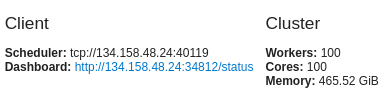

On this example we see that we have 100 nodes and almost 500 GB of memory attached to our notebook !
We also get the URL of the Dask cluster dash board. This URL will not work as is as it is located on a private network. In order to access it you need to open an `ssh` tunnel and forward the port (34812 in this case):

    ssh -J cca.in2p3.fr -X -Y -tt -L 9999:localhost:34812 ccwige0004.in2p3.fr

You will then need to type your password 2 times (one for `cca.in2p3.fr` and one for `ccwige004.in2p3.fr`). The `ssh` connection should be left open as long as you are using the dashboard.
You can now open the dash board by typing `localhost:9999/status` in a web browser. The dashboard will allow you to monitor the Dask cluster

In [12]:
client

Client Scheduler: tcp://134.158.48.24:40119 Dashboard: http://134.158.48.24:34812/status,Cluster Workers: 100 Cores: 100 Memory: 465.52 GiB


In [ ]:
print(cluster.scheduler_address)

In [5]:
# We provide the path to the directory where the parquet files are located.
# Note that one can provide a wildcard to restrict the analysis to a subsample of the files

data_path = "/sps/lsst/groups/desc/skysim5000_v1.1.1_native/skysim5000_v1.1.1_healpix6*.parquet"
# The following will allow to access to the whole dataset
#data_path = "/sps/lsst/groups/desc/shared/xgal/skysim/skysim5000_v1.1.1_parquet/skysim5000_v1.1.1_healpix*.parquet"

# Here we provide the list of columns that will be used in the analysis
# Note that the 2 last columns are only available on recent skysim5000 parquet files at cc-in2p3 and inding the "native" qauntities.
columns = ["ra", "dec", "redshift", "mag_u_lsst", "mag_g_lsst", "mag_r_lsst", "mag_i_lsst", "mag_z_lsst", "mag_y_lsst",
           "halo_id", "halo_mass", "is_central", "galaxy_id",
           "baseDC2/is_on_red_sequence_gr", "baseDC2/is_on_red_sequence_ri"]

# The following will only declare the Dask dataframe, nothing will be read out from disk at this step
df = dd.read_parquet(data_path, columns=columns, engine='pyarrow', kwargs={'dataset': {'use_legacy_dataset': False}})

In [6]:
df.columns

Index(['ra', 'dec', 'redshift', 'mag_u_lsst', 'mag_g_lsst', 'mag_r_lsst',
       'mag_i_lsst', 'mag_z_lsst', 'mag_y_lsst', 'halo_id', 'halo_mass',
       'is_central', 'galaxy_id', 'baseDC2/is_on_red_sequence_gr',
       'baseDC2/is_on_red_sequence_ri'],
      dtype='object')

In [7]:
# We can apply a cut and get a preview of the first 5 rows in the dataframe
df[df.halo_mass > 1.e+13].head()

,ra,dec,redshift,mag_u_lsst,mag_g_lsst,mag_r_lsst,mag_i_lsst,mag_z_lsst,mag_y_lsst,halo_id,halo_mass,is_central,galaxy_id,baseDC2/is_on_red_sequence_gr,baseDC2/is_on_red_sequence_ri
177,1.819182,-0.450413,0.058944,18.680296,16.966107,16.095616,15.690103,15.424283,15.214057,5506080464,1.290993e+13,True,6080000000177,True,True
178,1.858688,-0.390812,0.060835,22.756158,21.785960,21.377345,21.124830,20.989822,20.903354,5506080464,1.290993e+13,False,6080000000178,False,False
179,1.844373,-0.463940,0.059392,19.485086,17.831878,16.985828,16.540311,16.156551,15.960591,5506080464,1.290993e+13,False,6080000000179,True,True
180,1.786733,-0.418667,0.059590,21.795456,20.417810,19.703201,19.257644,18.908508,18.715938,5506080464,1.290993e+13,False,6080000000180,False,False
181,1.814883,-0.470912,0.060243,22.788012,21.280379,20.570048,20.177962,19.859733,19.682847,5506080464,1.290993e+13,False,6080000000181,False,False


In [8]:
# This the number of Dask partitions corresponding to the number of parquet files that are constituting the dataset
df.npartitions

251

In [9]:
# We now define some selection cuts
ra_min = 0
ra_max = 91
dec_min = -90
dec_max = +90

mass_min = 5.0e+13

z_min = 0.8
z_max = 1.2
mag_max = 27.5
mag_min = 18

cut = df.redshift > z_min
cut &= df.redshift < z_max
cut &= df.mag_r_lsst < mag_max
cut &= df.mag_g_lsst < mag_max
cut &= df.mag_i_lsst < mag_max
cut &= df.mag_r_lsst > mag_min
cut &= df.mag_g_lsst > mag_min
cut &= df.mag_i_lsst > mag_min
cut &= df.halo_mass > mass_min
cut &= (df.ra > ra_min) & (df.ra < ra_max)
cut &= (df.dec > dec_min) & (df.dec < dec_max)
cut &= df["baseDC2/is_on_red_sequence_ri"] == True

In [10]:
# And we apply those cuts on the dataframe. Nothing will be computed at this time
good = df[cut]

The big mistake at this point would be to try to plot something from the selected dataframe using matplotlib using the dask dataframe directly.
matplotlib is not Dask aware and plotting would be extremely inefficient and slow. One should instead use `holoview` and `datashader` (see Michael Wood-Vasey's examples) or tell dask to actually read the data and load it in a dataframe.

With this example this should take less than a minute. If you monitor the things with the dashboard you will see that the 100 nodes are running in parallel to access the data.

Of course thios is only working if the selection is returning a "reasonable" amount of rows. If the selection is larger and the resulting dataframe doesn't fit in memory, you will have to figure out a more clever way of using Dask (there are a lot !)

In [11]:
%%time
df2 = good.compute()

CPU times: user 868 ms, sys: 97.4 ms, total: 965 ms
Wall time: 40.6 s


In [12]:
df2

,ra,dec,redshift,mag_u_lsst,mag_g_lsst,mag_r_lsst,mag_i_lsst,mag_z_lsst,mag_y_lsst,halo_id,halo_mass,is_central,galaxy_id,baseDC2/is_on_red_sequence_gr,baseDC2/is_on_red_sequence_ri
243308,1.148672,-0.852694,0.822079,27.572690,26.204850,24.729355,23.665301,23.083771,22.892460,26506080272,1.165753e+14,False,6080000243308,True,True
243313,1.144774,-0.847502,0.822923,25.646411,24.251452,22.527103,21.398940,20.657071,20.413329,26506080272,1.165753e+14,False,6080000243313,True,True
243316,1.149460,-0.842742,0.820703,25.990608,24.779432,23.215497,22.131727,21.475118,21.256383,26506080272,1.165753e+14,False,6080000243316,True,True
243318,1.160500,-0.851253,0.821945,27.351957,26.067064,24.464298,23.385624,22.722910,22.497658,26506080272,1.165753e+14,False,6080000243318,True,True
243322,1.149479,-0.845005,0.823004,27.628314,26.359023,24.836781,23.752476,23.129927,22.924136,26506080272,1.165753e+14,False,6080000243322,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1223215,64.424769,-7.921845,1.159166,28.091784,27.102671,25.567343,24.502554,23.634853,23.070957,4475006999224,6.123637e+13,False,6999101836943,True,True
1223216,64.430368,-7.922877,1.144962,29.089450,27.143773,25.349668,24.226512,23.407702,22.799817,4475006999224,6.123637e+13,False,6999101836944,True,True
1223217,64.431928,-7.922874,1.150344,28.955650,27.119856,25.450052,24.353422,23.539667,22.940454,4475006999224,6.123637e+13,False,6999101836945,True,True
1223218,64.424618,-7.924241,1.152772,28.777220,26.941425,25.271622,24.174991,23.361236,22.762026,4475006999224,6.123637e+13,False,6999101836946,True,True


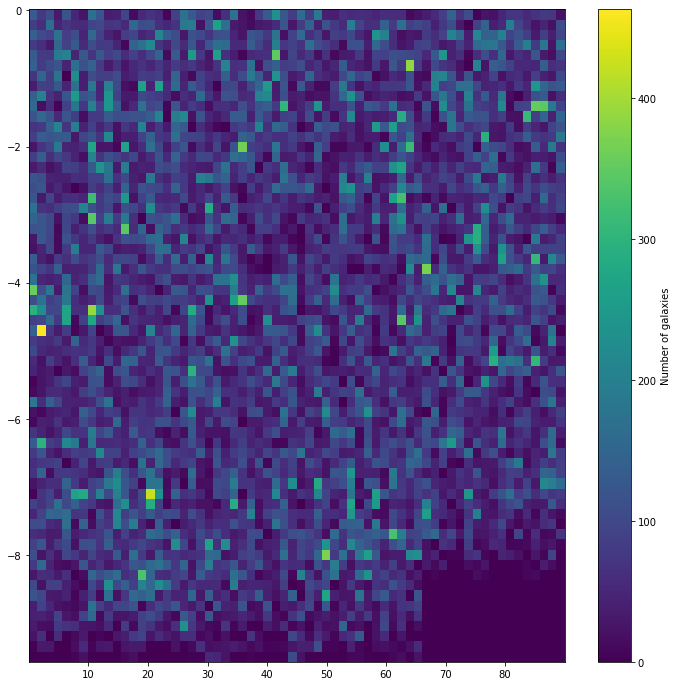

In [13]:
# We can now make a plot using matplotlib
plt.figure(figsize=(12, 12))
plt.hist2d(df2.ra, df2.dec, 64, cmap='viridis')
plt.colorbar(label='Number of galaxies');

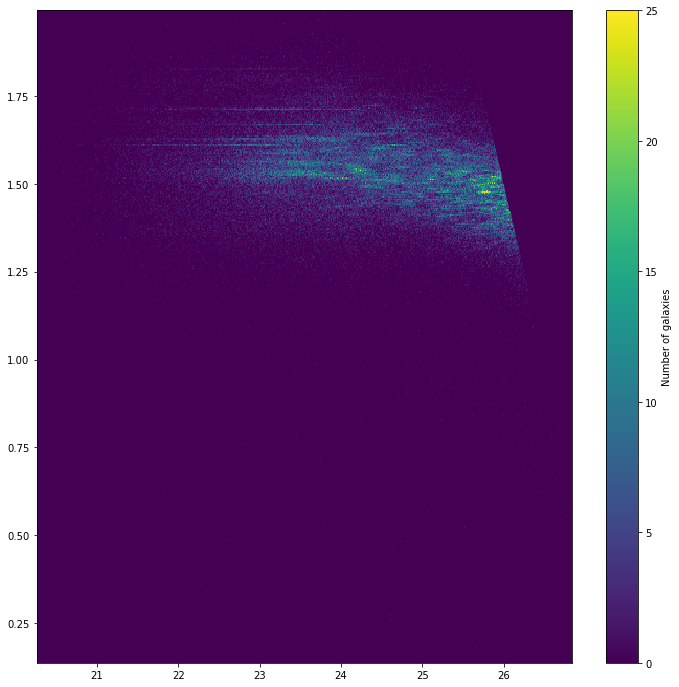

In [14]:
cut2 = (df2.redshift > 0.8) & (df2.redshift < 0.9)
plt.figure(figsize=(12, 12))
plt.hist2d(df2[cut2].mag_r_lsst, df2[cut2].mag_g_lsst-df2[cut2].mag_r_lsst, 512, cmap='viridis')
plt.colorbar(label='Number of galaxies');

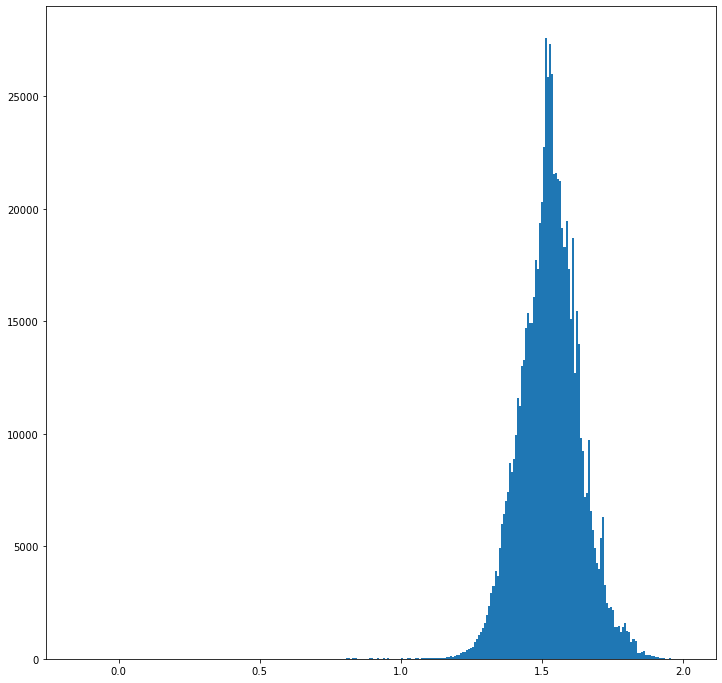

In [74]:
plt.figure(figsize=(12, 12))
_ = plt.hist(df2[cut2].mag_g_lsst-df2[cut2].mag_r_lsst, bins=300)

In [ ]:
# You can shutdown the cluster if you don't use it anymore. If you don't stop it, it will automatically timeout after some time.
cluster.close()